In [47]:
"""Rotation curves computation and plotting."""

using Pkg
Pkg.activate(".")
using AlgebraOfGraphics, CairoMakie
using PyCall
using DelimitedFiles
using CSV
using DataFrames

  Activating project at `/mnt/md1/mmestre/work/2020/halostream/sources/stream_fit/pipeline_paper`


In [26]:

pushfirst!(PyVector(pyimport("sys")."path"), "")
importLib = pyimport("importlib")
stream = pyimport("stream")
potentials = pyimport("potential_classes")
galpy_pots =  pyimport("galpy.potential")
u = pyimport("astropy.units")
importLib.reload(stream)

PyObject <module 'stream' from '/mnt/md1/mmestre/work/2020/halostream/sources/stream_fit/pipeline_paper/stream.py'>

In [9]:
# Parameters and initial conditions.
param_file = "param_fit_pot_from_IbataPolysGaiaDR2_chi2full.txt"
θ, ω, β = readdlm(param_file)

ϵ = 56.0
W = θ+ω
param = [ϵ, θ, W, β]


ic_file = "param_fit_orbit_from_IbataPolysGaiaDR2-data_fixedpot.txt"
ic = readdlm(ic_file)
r☼ = 8.122

orbit_nfw_file = "observable_orbit_NFW-MW.txt"

"observable_orbit_NFW-MW.txt"

In [71]:
# Fermionic-MW solution and rotation curve
pot_list = stream.pot_model(ϵ, θ, W, β)
halo = pot_list[4]
r = 10 .^ range(log10(halo.r_s[begin]),log10(100.),length=2000)
v_f = [stream.rot_vel_mw(pot_list, x) for x in r]

# NFW-MW solution and rotation curve
function malhan_vcirc(r)
    bp= galpy_pots.PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/8.0,normalize=0.05)
    mp= galpy_pots.MiyamotoNagaiPotential(a=3.0/8.0,b=0.28/8.0,normalize=0.6)
    hp= galpy_pots.TriaxialNFWPotential(a=16.0/8.0,b=1.0,c=0.82,normalize=0.59)
    mw = bp+mp+hp
    v0=mw[1].vcirc(r*u.kpc)
    v1=mw[2].vcirc(r*u.kpc)
    v2=mw[3].vcirc(r*u.kpc)
    return sqrt(v0*v0+v1*v1+v2*v2)*220.0
end
v_nfw = [malhan_vcirc(x) for x in r];
df_models = DataFrame(r=r, v_nfw=v_nfw, v_f=v_f)

Row,r,v_nfw,v_f
,Float64,Float64,Float64
1,4.00119e-13,5.76592,0.00948013
2,4.0681e-13,5.77549,0.00963867
3,4.13613e-13,5.78507,0.00979985
4,4.2053e-13,5.79468,0.00996373
5,4.27562e-13,5.80429,0.0101304
6,4.34712e-13,5.81393,0.0102998
7,4.41982e-13,5.82358,0.010472
8,4.49373e-13,5.83324,0.0106471
9,4.56888e-13,5.84293,0.0108252


In [94]:
 # Reading rotation curve observables
 # Set rotation data

 df_Sof13 = DataFrame(CSV.File("data_rotcurves/vel_Sofue13.txt"; delim=" ", ignorerepeated=true))
 df_Sof20 = DataFrame(CSV.File("data_rotcurves/vel_Sofue20.txt"; delim=" ", ignorerepeated=true))
 df_Eilers = DataFrame(CSV.File("data_rotcurves/vel_Eilers.txt"; delim=" ", ignorerepeated=true))
# asym_error = DataFrame([v_Eilers.e_down, v_Eilers.e_up])
df_Sof13


Row,r,v,err_r,err_v
,Float64,Float64,Float64,Float64
1,1.12,121.0,0.255,18.2
2,1.46,108.0,0.359,17.2
3,1.9,97.5,0.463,16.0
4,2.47,93.5,1.02,20.1
5,4.18,97.9,0.546,30.0
6,5.43,98.2,1.22,30.8
7,11.9,109.0,2.64,42.5
8,15.5,112.0,2.66,41.8
9,20.2,107.0,5.49,37.1


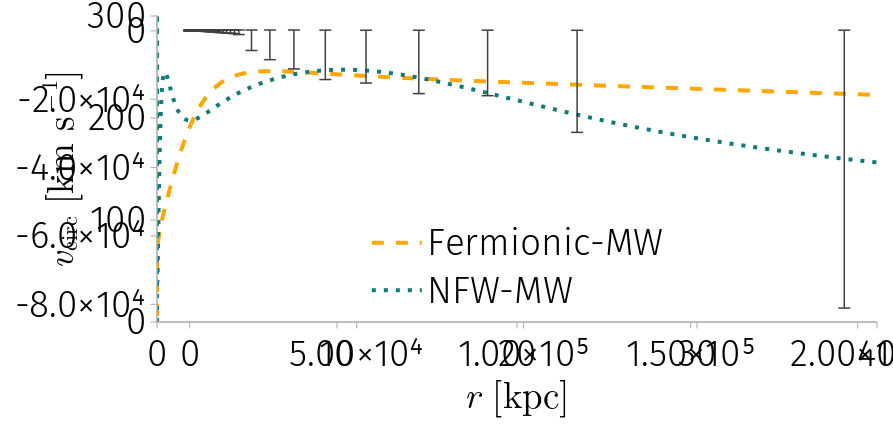

plot done.


In [105]:
labels = ["Fermionic-MW","NFW-MW"]
lw = 4
# %%

# Plot
let
      set_aog_theme!()
      size_inches = (6.2*2, 3*2)
      size_pt = 72 .* size_inches
      fig = Figure(resolution = size_pt, fontsize = 37)
      gridpos = fig[1, 1]
      grp = dims(1) => renamer(labels) => ""
      plt = data(df_models) *
          mapping(:r => L"r~[\textrm{kpc}]", [2,3] .=> L"v_{\textrm{circ}}~[\textrm{km s}^{-1}]";
              color = grp,
              linestyle = grp
          ) *
          visual(Lines, linewidth=lw)
      f = draw!(gridpos, plt, axis=(;limits=((0,40),(0,300)),
            xgridvisible=false, ygridvisible=false))
      legend!(gridpos, f; tellwidth=false, halign=:center, valign=:bottom, margin=(10, 10, 10, 10), patchsize=(50,35))
      ax = Axis(gridpos)
      errorbars!(ax, df_Sof13.r, df_Sof13.v, df_Sof13.err_r, df_Sof13.err_v; whiskerwidth = 12)
      # Lines re-styling
      amber_aog = "#ffa700"
      green_aog = "#107A78"
      lineas = fig.content[1].scene.plots
      lineas[1].linestyle = :dash
      lineas[2].linestyle = :dot
      lineas[1].color = amber_aog
      lineas[2].color = green_aog

      leg = fig.content[2]
      _lines = leg.blockscene.children[1].plots[2:3]
      for l in _lines
            l.linewidth = 4
      end
      _lines[1].linestyle = :dash
      _lines[2].linestyle = :dot
      _lines[1].color = amber_aog
      _lines[2].color = green_aog
      
      display(fig)
      save("paper_plots/rotation_curves.pdf", fig, pt_per_unit = 1)
      println("plot done.")
end

In [99]:
df_Sof13.err_v

61-element Vector{Float64}:
  18.2
  17.2
  16.0
  20.1
  30.0
  30.8
  42.5
  41.8
  37.1
  21.6
   ⋮
  59.9
  70.6
  75.1
  64.5
  56.3
  49.6
  58.2
  64.1
 110.0